In [1]:
import pandas as pd
import numpy as np

In [ ]:
df_test = pd.read_parquet('test_with_feats_v1.parquet')

In [ ]:
df_test.head()

In [ ]:
df_test.shape

In [ ]:
df_train = pd.read_parquet('train_with_feats_v1.parquet')

In [ ]:
df_train.shape

In [ ]:
df_train.head()

In [ ]:
df_train_cut = df_train.iloc[:, :-11]

In [ ]:
df_train_cut

In [4]:
df_origin = pd.read_parquet('train_dataset')

In [5]:
df_customer_datediffpoststats = df_origin.groupby(['customer_id']).agg({'date_diff_post': ['mean', 'max', 'min']})
df_customer_datediffpoststats.reset_index(inplace=True)
df_customer_datediffpoststats.columns = ['customer_id', 'mean', 'max', 'min']
df_customer_datediffpoststats

,customer_id,mean,max,min
0,29891,9.0,9.0,9.0
1,30477,10.0,10.0,10.0
2,31426,4.0,4.0,4.0
3,44491,42.0,42.0,42.0
4,44939,9.0,9.0,9.0
...,...,...,...,...
499995,46624509,NaN,NaN,NaN
499996,46625265,NaN,NaN,NaN
499997,46639170,10.0,10.0,10.0
499998,46654016,15.0,15.0,15.0


In [6]:
df_customer_lastdatediffpost = df_origin.sort_values(by=['startdatetime']).drop_duplicates('customer_id', keep='last')[['customer_id', 'date_diff_post']]

In [14]:
 df_targets = pd.merge(df_customer_datediffpoststats, df_customer_lastdatediffpost, on='customer_id')

In [15]:
df_targets

,customer_id,mean,max,min,date_diff_post
0,29891,9.0,9.0,9.0,9.0
1,30477,10.0,10.0,10.0,10.0
2,31426,4.0,4.0,4.0,4.0
3,44491,42.0,42.0,42.0,42.0
4,44939,9.0,9.0,9.0,9.0
...,...,...,...,...,...
499995,46624509,NaN,NaN,NaN,NaN
499996,46625265,NaN,NaN,NaN,NaN
499997,46639170,10.0,10.0,10.0,10.0
499998,46654016,15.0,15.0,15.0,15.0


In [ ]:
df_targets_nonchurn_only = df_targets.dropna()

In [ ]:
df_targets_nonchurn_only

In [ ]:
df_with_feats = pd.merge(df_targets_nonchurn_only, df_train_cut, on='customer_id')

In [ ]:
df_with_feats = df_with_feats.dropna()

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
df_feats = df_with_feats.iloc[:, 6:]


df_feats = scaler.fit_transform(df_feats)

In [215]:
df_feats.shape

(359095, 35)

In [ ]:
df_with_feats

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df_feats, df_with_feats['date_diff_post'], test_size=0.2, random_state=42)

In [ ]:
df_train.shape

In [ ]:
df_val.shape

In [ ]:
y_train

In [ ]:
df_val

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)



In [ ]:
model.predict(X_val)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
model.coef_

In [ ]:
y_pred = model.predict(X_val)
# The coefficients
print("Coefficients: \n", model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_val, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_val, y_pred))

In [ ]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
yhat = dt.predict(X_val)
r2_score(y_val, yhat), mean_squared_error(y_val, yhat)


In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgbm
import xgboost as xg

#generic function to fit model and return metrics for every algorithm
def boost_models(x):
    #transforming target variable through quantile transformer
    regr_trans = TransformedTargetRegressor(regressor=x, transformer=QuantileTransformer(output_distribution='normal'))
    regr_trans.fit(X_train, y_train)
    yhat = regr_trans.predict(X_val)
    algoname= x.__class__.__name__
    return algoname, round(r2_score(y_val, yhat),3), round(mean_squared_error(y_val, yhat),2), round(np.sqrt(mean_squared_error(y_val, yhat)),2)

algo=[GradientBoostingRegressor(), lgbm.LGBMRegressor(), xg.XGBRFRegressor()]
score=[]
for a in algo:
    score.append(boost_models(a))

 #Collate all scores in a table
pd.DataFrame(score, columns=['Model', 'Score', 'MAE', 'RMSE'])

In [ ]:
#generic function to fit model and return metrics for every algorithm
def boost_models(x):
    #transforming target variable through quantile transformer
    # regr = TransformedTargetRegressor(regressor=x, transformer=QuantileTransformer(output_distribution='normal'))
    x.fit(X_train, y_train)
    yhat = x.predict(X_val)
    algoname= x.__class__.__name__
    return algoname, round(r2_score(y_val, yhat),3), round(mean_squared_error(y_val, yhat),2), round(np.sqrt(mean_squared_error(y_val, yhat)),2)

algo=[GradientBoostingRegressor(), lgbm.LGBMRegressor(), xg.XGBRFRegressor()]
score=[]
for a in algo:
    score.append(boost_models(a))

 #Collate all scores in a table
pd.DataFrame(score, columns=['Model', 'Score', 'MAE', 'RMSE'])

In [ ]:
# random forest regressor
# ExtraTreesRegressor


In [ ]:
from sklearn.ensemble import AdaBoostRegressor

# попробовать поменять base estimator
model = AdaBoostRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

mean_squared_error(y_pred, y_val)

In [ ]:
np.sqrt(mean_squared_error(y_pred, y_val))

In [ ]:
model = AdaBoostRegressor(base_estimator=LinearRegression())
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

np.sqrt(mean_squared_error(y_pred, y_val))

In [ ]:
df_with_feats

In [ ]:
# corr? какая-то херня с признаками? почему всё так плохо??
# убрать какие-то признаки?

In [ ]:
df_with_feats.corr()

In [ ]:
lm = LinearRegression()
lm.fit(X_train, y_train)

In [ ]:
lm.coef_

In [ ]:
import seaborn as sns

sns.heatmap(df_with_feats.corr())

In [ ]:
lm.coef_

In [ ]:
df_coefs = pd.DataFrame(zip(df_with_feats.columns[6:], lm.coef_))
df_coefs

In [ ]:
df_coefs.columns = ['feature', 'coef']

In [ ]:
new_features = np.where(df_coefs[df_coefs.coef < 1000])

In [ ]:
# уберем фичи, которые всё ломают (у которых гигантские коэффициенты)

df_with_filtered_feats = df_with_feats[[
    ''
]]

In [ ]:
new_features

In [ ]:
scaler = preprocessing.StandardScaler()
df_feats = df_with_feats[new_features]
df_feats = scaler.fit_transform(df_feats)

In [ ]:
df_feats

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_feats, df_with_feats['date_diff_post'], test_size=0.2, random_state=42)

In [ ]:
lm2 = LinearRegression()
lm2.fit(X_train, y_train)
y_pred = lm2.predict(X_val)
np.sqrt(mean_squared_error(y_pred, y_val))

In [312]:
lm2.coef_

array([-5.21661839e-01, -3.47096073e-01, -5.39873008e+00, -8.66745080e-01,
       -9.52275868e-01,  7.33732680e-01, -9.47573581e-01,  3.15005959e-02,
        1.62288170e+00,  9.31627117e-01, -8.60006023e-01, -2.59145977e-01,
        2.07787207e+00,  3.45277148e-01,  6.87987441e-01,  6.59975560e-01,
       -5.56354161e-01,  3.30369892e+00, -3.08728392e-01,  6.59975560e-01,
       -3.60024214e-02, -8.16137996e-02,  1.19877119e+00,  1.63534715e-02,
       -3.60024214e-02, -8.16137996e-02, -1.63927405e-01,  4.06563293e-03,
       -1.49820103e+00,  1.83158593e+00, -1.39289275e-01,  1.17633120e-01,
       -5.48189876e+00,  4.81989014e+00,  7.96694986e-01])

In [ ]:
np.sqrt(209.01)

In [ ]:
sns.heatmap(pd.DataFrame(df_feats).corr())

In [ ]:
df_feats

In [ ]:
r2_score(y_val, y_pred)

In [ ]:
df_feats = pd.DataFrame(df_feats, columns=new_features)

In [315]:
df_feats

,receipt_sum_mean,receipt_sum_std,receipt_count,items_receipt_mean,items_receipt_mean_std,sum_delta_min,sum_delta_max,sum_delta_mean,sum_delta_std,count_delta_min,...,revenue_sum_sum_28d,items_count_std_28d,sqm_place_mean,sqm_place_std,sqm_place_sem,sqm_place_var,minutes_mean,minutes_std,minutes_sem,minutes_var
0,-0.982142,-0.659256,3.288781,-1.408442,-0.852808,0.275708,-0.198489,0.118780,-0.604853,0.237140,...,-0.326403,-0.478527,2.415665,-0.129241,-0.497223,-0.321485,-1.974069,1.282057,-0.268184,0.888278
1,-0.901768,-0.650484,3.288781,-0.920119,-0.175382,0.044140,-0.028654,0.091563,-0.614212,-0.628832,...,1.004428,-0.210659,1.083898,-0.862113,-0.801301,-0.464644,-2.035432,0.104045,-0.741115,-0.123561
2,-0.340290,0.393886,3.112109,-0.403159,-0.180143,-1.169180,1.356387,0.104466,0.293719,-0.340175,...,3.548137,0.035481,-0.627437,-0.862113,-0.801301,-0.464644,0.068577,0.425231,-0.595462,0.100616
3,-1.237540,-0.553276,-0.421329,-0.892989,-1.034215,0.354341,-0.937487,-0.464341,-0.612586,0.814454,...,-0.905636,-0.803623,-0.900482,-0.451449,-0.375327,-0.419694,1.928065,-0.424385,-0.249556,-0.408042
4,0.218346,-1.023366,-0.598001,1.744559,-0.663971,0.921649,-1.104930,-0.205107,-1.116952,0.525797,...,-0.171237,-0.466373,-0.355741,0.550999,0.891252,0.067607,0.235931,1.739888,2.440125,1.422229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359090,-0.471457,-0.626656,-0.598001,0.388106,2.353113,0.477060,-0.889694,-0.522439,-0.546751,-1.494804,...,-0.558148,2.281842,0.366572,-0.862113,-0.801301,-0.464644,0.226634,0.112120,0.553656,-0.118400
359091,0.127303,-0.646043,-0.598001,-0.064046,-1.034215,0.458559,-0.746196,-0.360710,-0.409292,0.814454,...,-0.222303,-0.803623,0.430107,-0.687736,-0.592440,-0.456540,1.260974,-1.061424,-0.806400,-0.611508
359092,0.244055,0.329054,-0.421329,-0.666914,-0.497550,-0.317094,-0.674386,-1.449212,-0.088612,0.525797,...,0.202403,-0.314782,0.310211,-0.862113,-0.801301,-0.464644,-2.417906,5.659269,5.856383,9.216336
359093,-0.436251,-0.387252,-0.598001,-0.365480,-0.424885,1.315230,-0.435254,1.194289,-0.894566,1.391768,...,-0.538401,-0.248593,-1.373456,-0.862113,-0.801301,-0.464644,1.486436,-0.522332,-0.181630,-0.449245


In [ ]:
df_origin

In [ ]:
from matplotlib import pyplot as plt

for feature in new_features:
    sns.scatterplot(data=df_feats_y, x=feature, y='y_norm')
    plt.show()

In [ ]:
df_feats_y = pd.concat([df_feats, pd.DataFrame(y_normalized, columns=['y_norm'])])

In [ ]:
df_feats_y

In [ ]:
# а если вообще всё нормализовать

y_normalized = preprocessing.StandardScaler().fit_transform(np.array(df_with_feats['date_diff_post']).reshape(-1, 1))

In [ ]:
y_normalized

In [3]:
df_train_origin = pd.read_parquet('train_with_feats_v1.parquet')

In [10]:
df_train_origin = pd.merge(df_train_origin, df_targets, on='customer_id')

In [ ]:
df_train_origin_filled = df_train_origin.copy()

In [ ]:
df_train_origin_filled['date_diff_post'] = df_train_origin_filled['date_diff_post'].fillna(1000)

In [ ]:
df_train_origin_filled.plot.scatter('cosine_similarity', 'date_diff_post')

In [ ]:
# добавить убранные фичи
df_train = df_train_origin[df_train_origin.buy_post == 1].iloc[:, 6:]

In [ ]:
df_train

In [ ]:
y_train

In [ ]:
df_feats.shape

In [ ]:
df_with_feats['date_diff_post']

In [ ]:
X_train.shape

In [ ]:
y_train

In [ ]:
# делаем пайплайн

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X_train, x_val, y_train, y_val = train_test_split(df_feats, df_with_feats['date_diff_post'], test_size=0.2, random_state=42)

pipeline = Pipeline([('scaler', StandardScaler()), ('regression', LinearRegression())])
pipeline.fit(X_train, y_train)


In [ ]:
y_pred = pipeline.predict(x_val)

In [ ]:
np.sqrt(mean_squared_error(y_pred, y_val))

In [ ]:
# ограничить 5-60
# xgboost


In [230]:
# дать 70 для неотточенных

df_train_origin_filled['date_diff_post'] = df_train_origin['date_diff_post'].fillna(70)


In [231]:
df_train_origin_filled['date_diff_post']

0         70.0
1         70.0
2         70.0
3         70.0
4         70.0
          ... 
499995     3.0
499996     1.0
499997    55.0
499998    10.0
499999    15.0
Name: date_diff_post, Length: 500000, dtype: float64

In [306]:
df_train_origin_filled_X = df_train_origin_filled.iloc[:, 2:-1]

In [308]:
df_train_origin_filled_X = df_train_origin_filled_X.fillna(0)

In [309]:
X_train, x_val, y_train, y_val = train_test_split(df_train_origin_filled_X, df_train_origin_filled['date_diff_post'], test_size=0.2, random_state=49)

In [310]:
for x in [X_train, x_val, y_train, y_val]:
    print(x.shape)

(400000, 64)
(100000, 64)
(400000,)
(100000,)


In [311]:
pipeline = Pipeline([('scaler', StandardScaler()), ('regression', LinearRegression())])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(x_val)
np.sqrt(mean_squared_error(y_val, y_pred))

21.85727943235084

In [256]:
X_train

,receipt_sum_mean,receipt_sum_std,receipt_count,items_receipt_mean,items_receipt_mean_std,sum_delta_min,sum_delta_max,sum_delta_mean,sum_delta_std,count_delta_min,...,second_half_max,second_half_min,second_half_std,diff,ratio,cosine_similarity,mean,max,min,date_diff_post
269056,594.957500,182.658060,4,3.000000,1.414214,89.98,200.02,133.323333,58.619400,-1.0,...,799.94,689.97,77.760533,299.995000,1.674207,0.097222,53.0,53.0,53.0,53.0
499174,231.948571,152.188543,28,3.571429,3.765620,-751.97,481.99,-1.702963,240.834566,-17.0,...,752.97,1.00,202.055551,9.505714,1.041839,0.086200,5.0,5.0,5.0,5.0
85143,1254.912000,675.709129,5,5.800000,2.949576,-1764.94,1254.93,-92.507500,1248.015326,-7.0,...,2414.85,649.91,908.292602,383.286667,1.373960,0.074911,0.0,0.0,0.0,70.0
260335,427.560000,180.066159,19,2.789474,1.228321,-479.99,419.99,-25.000000,269.375760,-3.0,...,599.98,199.99,146.277585,-125.984778,0.744902,0.077252,6.0,6.0,6.0,6.0
338124,708.273333,427.890097,3,4.333333,2.081666,-459.92,-395.04,-427.480000,45.877088,-4.0,...,729.90,269.98,325.212551,-625.000000,0.444415,0.100592,7.0,7.0,7.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,914.290000,806.312769,9,6.222222,4.352522,-1897.93,1609.90,2.495000,1133.971198,-10.0,...,1119.95,2.00,441.375466,-771.583500,0.425455,0.036352,32.0,32.0,32.0,32.0
365838,329.070000,343.470469,10,2.400000,1.646545,-709.94,939.95,-16.108889,478.630429,-4.0,...,779.93,1.00,311.922142,-185.788000,0.559707,0.076389,3.0,3.0,3.0,3.0
131932,368.586000,521.621607,5,2.200000,1.643168,-394.99,1222.96,305.990000,717.120729,-3.0,...,1224.96,2.00,677.058725,192.660000,1.761532,0.090909,0.0,0.0,0.0,70.0
146867,324.685000,328.055965,14,3.071429,2.464027,-904.94,859.95,58.613077,529.647323,-7.0,...,949.93,44.99,413.207020,127.715714,1.489657,0.106544,17.0,17.0,17.0,17.0


In [263]:
lm = pipeline['regression']

In [266]:
lm.coef_

array([ 9.10804201e-15,  2.63955524e-14, -6.61692923e-14, -2.57571742e-14,
       -3.29181127e-14,  3.76920717e-14, -1.64313008e-14, -6.43929354e-15,
        2.30926389e-14, -2.66453526e-15,  7.27196081e-15, -4.88498131e-15,
        2.40363285e-14, -1.59872116e-14,  1.33365541e-14, -2.11689779e+00,
        7.94575960e-02,  1.39777450e+00,  9.58472222e-02, -8.11226367e-01,
       -8.09945015e-01,  4.50447232e-01, -1.21787504e-01,  4.37094563e-02,
        1.05105396e+00, -5.22998165e-02, -7.18559377e-01,  7.67879893e-03,
        4.48666719e-01,  4.17400163e-01, -2.36701946e-01,  4.19490722e-02,
       -1.81221721e-03,  1.06584383e+00, -2.71577794e-02, -6.79215124e-01,
       -1.03526021e-01,  3.62559648e-01,  3.92544852e-01, -2.13745286e-01,
        7.98384321e-02, -4.18972391e-02, -1.44328993e-15, -2.76445533e-14,
        2.75890422e-14,  8.88178420e-16,  5.66213743e-15, -8.37108161e-14,
        7.14983628e-14,  1.53072000e-14, -6.07582399e-01,  3.88578059e-16,
        1.49880108e-14,  

In [265]:
from sklearn.model_selection import cross_val_score

accuracies = cross_val_score(estimator = lm, X=x_val,y=y_val,scoring='neg_mean_squared_error', cv =10)
accuracies.mean()


-3.9725965587702024e-24

In [282]:
# оценим RMSE на нормальных данных, дропнув 70 из выборки
leave_indices = np.argwhere(y_val != 70)

In [290]:
y_val_non70 = np.array(y_val)[np.squeeze(leave_indices)]

In [292]:
x_val

,receipt_sum_mean,receipt_sum_std,receipt_count,items_receipt_mean,items_receipt_mean_std,sum_delta_min,sum_delta_max,sum_delta_mean,sum_delta_std,count_delta_min,...,second_half_max,second_half_min,second_half_std,diff,ratio,cosine_similarity,mean,max,min,date_diff_post
499182,953.283333,241.919684,3,8.000000,2.000000,-3.599700e+02,459.97,50.000000,579.785134,-2.0,...,1139.94,679.97,325.247906,-129.985000,0.875007,0.118056,3.0,3.0,3.0,3.0
290697,425.408788,240.506536,33,5.060606,3.220437,-6.739700e+02,828.96,0.782187,350.994524,-11.0,...,1134.95,239.99,222.489577,108.921912,1.294944,0.062856,1.0,1.0,1.0,1.0
427906,738.300000,287.927451,3,6.666667,2.081666,-2.600100e+02,574.98,157.485000,590.427091,-1.0,...,1034.95,459.97,406.572257,27.480000,1.038168,0.085000,5.0,5.0,5.0,5.0
389149,545.462500,123.121472,4,4.000000,0.000000,-5.684342e-14,237.99,83.326667,134.076471,0.0,...,729.95,491.96,168.284343,130.985000,1.272902,0.148438,9.0,9.0,9.0,9.0
78738,1407.402500,471.645225,4,5.500000,1.000000,-9.499100e+02,10.00,-313.303333,551.340218,-2.0,...,1649.88,699.97,671.687803,-464.955000,0.716470,0.132231,0.0,0.0,0.0,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416490,1058.961111,615.897405,9,7.111111,3.655285,-1.084950e+03,1217.94,2.506250,836.938784,-9.0,...,1839.96,2.00,696.650408,86.397500,1.085461,0.045898,14.0,14.0,14.0,14.0
465300,320.855000,296.323423,8,2.125000,0.991031,-8.099600e+02,738.97,-3.428571,503.436537,-2.0,...,979.95,95.99,406.079283,121.245000,1.465910,0.176471,30.0,30.0,30.0,30.0
242625,969.950000,281.279026,3,6.666667,4.041452,-5.489600e+02,380.95,-84.005000,657.545667,-7.0,...,1040.93,659.98,269.372328,-358.485000,0.703472,0.060000,14.0,14.0,14.0,14.0
23347,904.950000,676.698900,3,9.666667,5.033223,-8.349600e+02,-504.96,-669.960000,233.345238,-6.0,...,794.95,289.99,357.060640,-1087.440000,0.332822,0.058264,0.0,0.0,0.0,70.0


In [294]:
x_val_non70 = x_val.iloc[np.squeeze(leave_indices), :]

In [295]:
x_val_non70.shape

(71986, 65)

In [297]:
y_pred_non70 = pipeline['regression'].predict(x_val_non70)

C:\Users\rakhmerov\.virtualenvs\pythonProject3\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [301]:
y_pred_non70_pipelined = pipeline.predict(x_val_non70)

In [302]:
y_pred_non70_pipelined

array([ 3.,  1.,  5., ..., 30., 14.,  6.])

In [303]:
np.sqrt(mean_squared_error(y_val_non70, y_pred_non70_pipelined))

1.6676712258662565e-13

In [304]:
x_val_non70

,receipt_sum_mean,receipt_sum_std,receipt_count,items_receipt_mean,items_receipt_mean_std,sum_delta_min,sum_delta_max,sum_delta_mean,sum_delta_std,count_delta_min,...,second_half_max,second_half_min,second_half_std,diff,ratio,cosine_similarity,mean,max,min,date_diff_post
499182,953.283333,241.919684,3,8.000000,2.000000,-3.599700e+02,459.97,50.000000,579.785134,-2.0,...,1139.94,679.97,325.247906,-129.985000,0.875007,0.118056,3.0,3.0,3.0,3.0
290697,425.408788,240.506536,33,5.060606,3.220437,-6.739700e+02,828.96,0.782187,350.994524,-11.0,...,1134.95,239.99,222.489577,108.921912,1.294944,0.062856,1.0,1.0,1.0,1.0
427906,738.300000,287.927451,3,6.666667,2.081666,-2.600100e+02,574.98,157.485000,590.427091,-1.0,...,1034.95,459.97,406.572257,27.480000,1.038168,0.085000,5.0,5.0,5.0,5.0
389149,545.462500,123.121472,4,4.000000,0.000000,-5.684342e-14,237.99,83.326667,134.076471,0.0,...,729.95,491.96,168.284343,130.985000,1.272902,0.148438,9.0,9.0,9.0,9.0
331413,323.643333,224.058636,6,3.666667,1.861899,-5.079700e+02,317.97,-91.994000,331.252156,-3.0,...,319.97,2.00,159.111681,-332.646667,0.321083,0.078512,32.0,32.0,32.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383681,334.486667,254.178622,6,3.166667,1.722401,-5.699900e+02,519.99,-40.800000,422.369465,-3.0,...,769.98,50.99,379.481273,11.666667,1.035498,0.085873,26.0,26.0,26.0,26.0
416490,1058.961111,615.897405,9,7.111111,3.655285,-1.084950e+03,1217.94,2.506250,836.938784,-9.0,...,1839.96,2.00,696.650408,86.397500,1.085461,0.045898,14.0,14.0,14.0,14.0
465300,320.855000,296.323423,8,2.125000,0.991031,-8.099600e+02,738.97,-3.428571,503.436537,-2.0,...,979.95,95.99,406.079283,121.245000,1.465910,0.176471,30.0,30.0,30.0,30.0
242625,969.950000,281.279026,3,6.666667,4.041452,-5.489600e+02,380.95,-84.005000,657.545667,-7.0,...,1040.93,659.98,269.372328,-358.485000,0.703472,0.060000,14.0,14.0,14.0,14.0


In [314]:
models = [
    LinearRegression(),
    GradientBoostingRegressor(),
    AdaBoostRegressor(),
    DecisionTreeRegressor()
]

# pipeline = Pipeline([('scaler', StandardScaler()), ('regression', LinearRegression())])
# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(x_val)
# np.sqrt(mean_squared_error(y_val, y_pred))

for model in models:
    pipeline = Pipeline([('scaler', StandardScaler()), ('regressor', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(x_val)
    print(model.__class__, np.sqrt(mean_squared_error(y_val, y_pred)))

<class 'sklearn.linear_model._base.LinearRegression'> 21.85727943235084
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'> 0.31971252454448246
<class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'> 3.4908911838665384
<class 'sklearn.tree._classes.DecisionTreeRegressor'> 0.38340579025361626


In [317]:
def get_pipeline(model):
    return Pipeline([('scaler', StandardScaler()), ('regressor', model)])

In [320]:
# отдельно тренируем GradientBoostingRegressor

gb_pipe = get_pipeline(GradientBoostingRegressor())
gb_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', GradientBoostingRegressor())])

In [321]:
model = gb_pipe['regressor']


In [330]:
model.feature_importances_

array([0.00000000e+00, 1.41953904e-06, 3.46679260e-08, 1.82559231e-09,
       1.79035031e-07, 0.00000000e+00, 2.13518682e-09, 3.68945119e-09,
       6.24832436e-18, 0.00000000e+00, 0.00000000e+00, 9.29399210e-08,
       0.00000000e+00, 3.92141444e-07, 0.00000000e+00, 4.19955945e-10,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.47772145e-10,
       1.51414946e-09, 2.98123509e-08, 0.00000000e+00, 3.05867758e-07,
       1.17219509e-09, 3.73958800e-19, 0.00000000e+00, 4.93787755e-18,
       0.00000000e+00, 0.00000000e+00, 2.40861112e-08, 0.00000000e+00,
       6.01962592e-08, 1.44906285e-09, 1.31593794e-09, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.12883307e-09, 6.23669192e-08,
       0.00000000e+00, 1.03575480e-07, 6.19335380e-10, 3.65584365e-09,
       0.00000000e+00, 5.52217817e-09, 1.71284383e-05, 1.45093281e-20,
       2.59351369e-20, 1.76774279e-19, 7.02886710e-06, 1.29287345e-06,
       0.00000000e+00, 1.82747450e-05, 0.00000000e+00, 0.00000000e+00,
      

,buy_post,customer_id,receipt_sum_mean,receipt_sum_std,receipt_count,items_receipt_mean,items_receipt_mean_std,sum_delta_min,sum_delta_max,sum_delta_mean,...,second_half_max,second_half_min,second_half_std,diff,ratio,cosine_similarity,mean,max,min,date_diff_post
0,0,45006,522.613333,395.184669,3,6.333333,5.773503,-765.91,213.99,-275.960000,...,409.97,195.98,151.313780,-658.915000,0.314979,0.080332,NaN,NaN,NaN,NaN
1,0,45303,148.943478,88.418075,23,1.260870,0.751809,-250.00,288.99,-0.908182,...,259.99,39.99,80.267503,-2.173106,0.985520,0.086801,NaN,NaN,NaN,NaN
2,0,102488,186.978333,331.158229,6,3.000000,4.427189,-830.94,830.94,0.200000,...,860.93,29.99,473.797616,253.983333,5.233996,0.123457,NaN,NaN,NaN,NaN
3,0,119045,396.970000,191.625756,3,2.000000,1.000000,-300.97,-55.00,-177.985000,...,314.98,259.98,38.890873,-328.470000,0.466726,0.222222,NaN,NaN,NaN,NaN
4,0,157470,679.296667,621.355704,3,5.000000,3.605551,-806.96,-414.97,-610.965000,...,809.96,3.00,570.606888,-818.450000,0.331839,0.084444,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1,46598535,353.000000,129.722781,3,5.333333,5.859465,-242.00,40.00,-101.000000,...,299.00,259.00,28.284271,-222.000000,0.556886,0.125000,3.0,3.0,3.0,3.0
499996,1,46609455,528.290000,125.825938,3,4.333333,0.577350,-249.99,99.99,-75.000000,...,644.95,394.96,176.769624,-25.005000,0.954116,0.147929,1.0,1.0,1.0,1.0
499997,1,46617009,562.470000,321.818220,4,3.000000,1.414214,-584.98,130.01,-249.990000,...,699.97,114.99,413.643325,-309.980000,0.567948,0.166667,55.0,55.0,55.0,55.0
499998,1,46639170,363.306667,177.842347,3,3.666667,1.527525,119.99,229.98,174.985000,...,519.96,399.97,84.845743,289.975000,2.705836,0.355372,10.0,10.0,10.0,10.0


In [338]:
np.argwhere(model.feature_importances_ > 1e-5)

array([[46],
       [53],
       [61],
       [62],
       [63]], dtype=int64)

5 признаков всего. Посмотрим, что это:

In [345]:
np.array(df_train_origin_filled_X.columns)[np.argwhere(model.feature_importances_ > 1e-5)]

array([['minutes_mean'],
       ['first_half_std'],
       ['mean'],
       ['max'],
       ['min']], dtype=object)

## Decision Tree Regressor

DTR тоже показал очень маленький RMSE, но он тоже мог переобучиться. Пока адекватно выглядит только Adaboost

In [12]:
df_test = pd.read_parquet('test_with_feats_v2.parquet')
df_train = pd.read_parquet('train_with_feats_v2.parquet')

df_original_train = pd.read_parquet("train_dataset_hackaton2023_train.gzip")
df_targets_raw = df_original_train.sort_values(by=['startdatetime']).drop_duplicates('customer_id', keep='last')[['customer_id', 'date_diff_post']]

df_targets = df_targets_raw.fillna(70)

df_train = df_train.drop(columns=['buy_post', 'customer_id'])
df_train = df_train.fillna(0)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df_train, df_targets['date_diff_post'], test_size=0.2, random_state=42)

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

<Axes: >

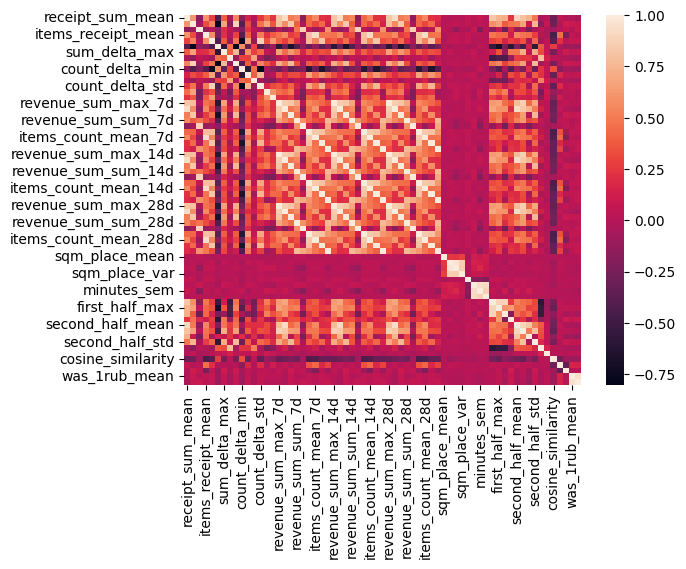

In [348]:
sns.heatmap(df_train.corr())

In [349]:
from sklearn.linear_model import LassoCV
model = LassoCV()
model.fit(X_train, y_train)

LassoCV()

In [350]:
model.coef_

array([-5.77099404e-05,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.48145978e-04, -4.34291839e-04, -0.00000000e+00,
        6.53727611e-04, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.53306320e-04,
       -2.46008438e-04, -0.00000000e+00, -8.23669318e-05, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        1.78464220e-04, -6.01337551e-05, -0.00000000e+00, -3.31553476e-05,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  9.99241020e-05, -4.12670071e-05, -0.00000000e+00,
       -1.76646082e-05, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  6.14060864e-04,  3.08845894e-03,
        0.00000000e+00, -1.18805905e-06, -0.00000000e+00, -3.80739022e-03,
        6.98104791e-03,  1.46096300e-06, -0.00000000e+00, -3.46359817e-04,
        5.31394217e-04, -

In [351]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold

In [352]:
# parameters to be tested on GridSearchCV
params = {"alpha":np.arange(0.00001, 10, 500)}

# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

# Initializing the Model
lasso = Lasso()

# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(X_train, y_train)
print("Best Params {}".format(lasso_cv.best_params_))

C:\Users\rakhmerov\.virtualenvs\pythonProject3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.557e+07, tolerance: 1.918e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\rakhmerov\.virtualenvs\pythonProject3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.534e+07, tolerance: 1.915e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\rakhmerov\.virtualenvs\pythonProject3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

Best Params {'alpha': 1e-05}


C:\Users\rakhmerov\.virtualenvs\pythonProject3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.194e+08, tolerance: 2.396e+04
  model = cd_fast.enet_coordinate_descent(


C:\Users\rakhmerov\.virtualenvs\pythonProject3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.194e+08, tolerance: 2.396e+04
  model = cd_fast.enet_coordinate_descent(


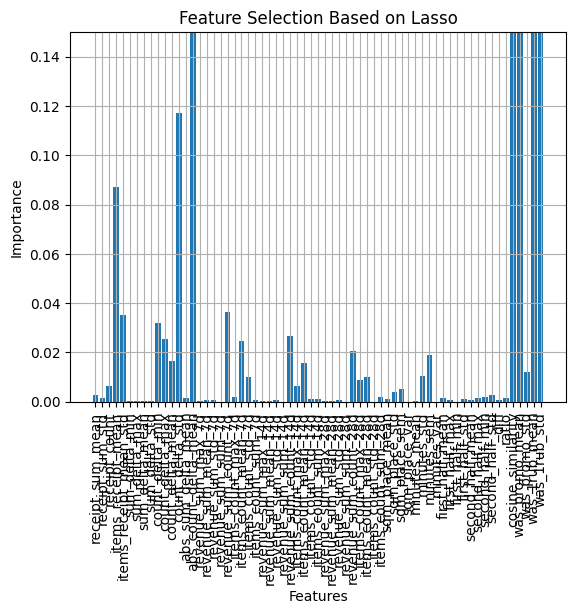

In [353]:

# calling the model with the best parameter
lasso1 = Lasso(alpha=1e-5)
lasso1.fit(X_train, y_train)

# Using np.abs() to make coefficients positive.
lasso1_coef = np.abs(lasso1.coef_)

# plotting the Column Names and Importance of Columns.
plt.bar(df_train.columns, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.ylim(0, 0.15)
plt.show()

In [354]:
# Subsetting the features which has more than 0.001 importance.
feature_subset=np.array(df_train.columns)[lasso1_coef>0.001]
print("Selected Feature Columns: {}".format(feature_subset))


Selected Feature Columns: ['receipt_sum_mean' 'receipt_sum_std' 'receipt_count' 'items_receipt_mean'
 'items_receipt_mean_std' 'count_delta_min' 'count_delta_max'
 'count_delta_mean' 'count_delta_std' 'abs_sum_delta_mean'
 'abs_count_delta_mean' 'revenue_sum_count_7d' 'items_count_max_7d'
 'items_count_mean_7d' 'items_count_std_7d' 'revenue_sum_count_14d'
 'items_count_max_14d' 'items_count_mean_14d' 'items_count_std_14d'
 'items_count_sum_14d' 'revenue_sum_count_28d' 'items_count_max_28d'
 'items_count_mean_28d' 'items_count_sum_28d' 'sqm_place_mean'
 'sqm_place_std' 'sqm_place_sem' 'minutes_std' 'minutes_sem'
 'first_half_mean' 'second_half_max' 'second_half_min' 'second_half_std'
 'ratio' 'cosine_similarity' 'was_promo_mean' 'was_promo_std'
 'was_1rub_mean' 'was_1rub_std']


In [369]:
y_pred = lasso1.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

24.425769067057907

In [28]:
def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    return np.sqrt(mean_squared_error(y_val, y_pred))

In [370]:
df_train_feature_subset = df_train[feature_subset]
X_train, X_val, y_train, y_val = train_test_split(df_train, df_targets['date_diff_post'], test_size=0.2, random_state=42)


In [372]:
lm = LinearRegression()
lm.fit(X_train, y_train)
evaluate_model(lm, X_val, y_val)

24.425769254241747

# Обучаемся только на хороших данных

In [16]:
df_all_data = pd.merge(df_train_origin, df_targets_raw, on='customer_id')

In [17]:
df_train_origin

,buy_post,customer_id,receipt_sum_mean,receipt_sum_std,receipt_count,items_receipt_mean,items_receipt_mean_std,sum_delta_min,sum_delta_max,sum_delta_mean,...,second_half_max,second_half_min,second_half_std,diff,ratio,cosine_similarity,mean,max,min,date_diff_post
0,0,45006,522.613333,395.184669,3,6.333333,5.773503,-765.91,213.99,-275.960000,...,409.97,195.98,151.313780,-658.915000,0.314979,0.080332,NaN,NaN,NaN,NaN
1,0,45303,148.943478,88.418075,23,1.260870,0.751809,-250.00,288.99,-0.908182,...,259.99,39.99,80.267503,-2.173106,0.985520,0.086801,NaN,NaN,NaN,NaN
2,0,102488,186.978333,331.158229,6,3.000000,4.427189,-830.94,830.94,0.200000,...,860.93,29.99,473.797616,253.983333,5.233996,0.123457,NaN,NaN,NaN,NaN
3,0,119045,396.970000,191.625756,3,2.000000,1.000000,-300.97,-55.00,-177.985000,...,314.98,259.98,38.890873,-328.470000,0.466726,0.222222,NaN,NaN,NaN,NaN
4,0,157470,679.296667,621.355704,3,5.000000,3.605551,-806.96,-414.97,-610.965000,...,809.96,3.00,570.606888,-818.450000,0.331839,0.084444,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1,46598535,353.000000,129.722781,3,5.333333,5.859465,-242.00,40.00,-101.000000,...,299.00,259.00,28.284271,-222.000000,0.556886,0.125000,3.0,3.0,3.0,3.0
499996,1,46609455,528.290000,125.825938,3,4.333333,0.577350,-249.99,99.99,-75.000000,...,644.95,394.96,176.769624,-25.005000,0.954116,0.147929,1.0,1.0,1.0,1.0
499997,1,46617009,562.470000,321.818220,4,3.000000,1.414214,-584.98,130.01,-249.990000,...,699.97,114.99,413.643325,-309.980000,0.567948,0.166667,55.0,55.0,55.0,55.0
499998,1,46639170,363.306667,177.842347,3,3.666667,1.527525,119.99,229.98,174.985000,...,519.96,399.97,84.845743,289.975000,2.705836,0.355372,10.0,10.0,10.0,10.0


In [20]:
df_additional_features = pd.read_parquet('train_additional_feats.parquet')

In [21]:
df_train_origin = pd.merge(df_train_origin, df_additional_features, on='customer_id')

In [22]:
df_train_origin

,buy_post,customer_id,receipt_sum_mean,receipt_sum_std,receipt_count,items_receipt_mean,items_receipt_mean_std,sum_delta_min,sum_delta_max,sum_delta_mean,...,is_sauce_mean,is_sauce_std,with_toilet_std,with_toilet_mean,food_court_std,food_court_mean,countable_std,countable_mean,external_area_std,external_area_mean
0,0,45006,522.613333,395.184669,3,6.333333,5.773503,-765.91,213.99,-275.960000,...,0.052632,0.229416,0.374634,0.157895,0.374634,0.842105,0.418854,0.210526,0.000000,0.000000
1,0,45303,148.943478,88.418075,23,1.260870,0.751809,-250.00,288.99,-0.908182,...,0.241379,0.435494,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0,102488,186.978333,331.158229,6,3.000000,4.427189,-830.94,830.94,0.200000,...,0.166667,0.383482,0.383482,0.833333,0.383482,0.166667,0.323381,0.111111,0.427793,0.777778
3,0,119045,396.970000,191.625756,3,2.000000,1.000000,-300.97,-55.00,-177.985000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.516398,0.333333,0.000000,0.000000
4,0,157470,679.296667,621.355704,3,5.000000,3.605551,-806.96,-414.97,-610.965000,...,0.333333,0.487950,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1,46598535,353.000000,129.722781,3,5.333333,5.859465,-242.00,40.00,-101.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.341565,0.125000,0.000000,1.000000
499996,1,46609455,528.290000,125.825938,3,4.333333,0.577350,-249.99,99.99,-75.000000,...,0.230769,0.438529,0.000000,1.000000,0.000000,0.000000,0.518875,0.461538,0.000000,1.000000
499997,1,46617009,562.470000,321.818220,4,3.000000,1.414214,-584.98,130.01,-249.990000,...,0.166667,0.389249,0.000000,1.000000,0.000000,0.000000,0.389249,0.166667,0.000000,0.000000
499998,1,46639170,363.306667,177.842347,3,3.666667,1.527525,119.99,229.98,174.985000,...,0.181818,0.404520,0.000000,0.000000,0.000000,1.000000,0.404520,0.181818,0.000000,0.000000


In [23]:
df_non_churn_only = df_train_origin[df_train_origin.buy_post == 1]

In [24]:
df_train_non_churn_only = df_non_churn_only.drop(columns=['buy_post', 'customer_id', 'date_diff_post', 'mean', 'max', 'min']).fillna(0)
df_target_non_churn_only = df_non_churn_only['date_diff_post']

In [25]:
df_train_non_churn_only

,receipt_sum_mean,receipt_sum_std,receipt_count,items_receipt_mean,items_receipt_mean_std,sum_delta_min,sum_delta_max,sum_delta_mean,sum_delta_std,count_delta_min,...,is_sauce_mean,is_sauce_std,with_toilet_std,with_toilet_mean,food_court_std,food_court_mean,countable_std,countable_mean,external_area_std,external_area_mean
140905,203.494000,123.170275,25,1.360000,0.860233,-328.96,328.96,2.083750,179.086269,-3.0,...,0.088235,0.287902,0.000000,1.00,0.000000,0.00,0.171499,0.029412,0.359491,0.147059
140906,227.024000,124.933425,25,2.440000,1.916594,-428.97,399.96,-2.291667,175.813414,-6.0,...,0.180328,0.387651,0.000000,1.00,0.000000,0.00,0.300273,0.098361,0.000000,1.000000
140907,391.399583,334.849322,24,3.583333,1.909169,-952.98,978.98,-0.217391,493.313488,-5.0,...,0.418605,0.496224,0.000000,0.00,0.000000,1.00,0.235380,0.058140,0.000000,0.000000
140908,128.725000,144.471912,4,2.500000,0.577350,-295.00,20.02,-91.660000,176.381878,-1.0,...,0.000000,0.000000,0.000000,0.00,0.421637,0.20,0.000000,0.000000,0.421637,0.800000
140909,554.943333,49.985000,3,8.333333,1.154701,-49.99,-49.98,-49.985000,0.007071,-2.0,...,0.280000,0.458258,0.458258,0.28,0.458258,0.72,0.374166,0.160000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,353.000000,129.722781,3,5.333333,5.859465,-242.00,40.00,-101.000000,199.404112,-9.0,...,0.000000,0.000000,0.000000,1.00,0.000000,0.00,0.341565,0.125000,0.000000,1.000000
499996,528.290000,125.825938,3,4.333333,0.577350,-249.99,99.99,-75.000000,247.473231,-1.0,...,0.230769,0.438529,0.000000,1.00,0.000000,0.00,0.518875,0.461538,0.000000,1.000000
499997,562.470000,321.818220,4,3.000000,1.414214,-584.98,130.01,-249.990000,359.613821,-2.0,...,0.166667,0.389249,0.000000,1.00,0.000000,0.00,0.389249,0.166667,0.000000,0.000000
499998,363.306667,177.842347,3,3.666667,1.527525,119.99,229.98,174.985000,77.774675,1.0,...,0.181818,0.404520,0.000000,0.00,0.000000,1.00,0.404520,0.181818,0.000000,0.000000


In [26]:
def quick_evaluate_model(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    return evaluate_model(model, X_val, y_val)

In [29]:
quick_evaluate_model(LinearRegression(), df_train_non_churn_only, df_target_non_churn_only)

14.442221728647583

In [428]:
quick_evaluate_model(LinearRegression(), df_train_non_churn_only, df_target_non_churn_only)

14.442221728647583

In [431]:
# добавляем scaler

pipeline = Pipeline([('scaler', StandardScaler()), ('regressor', LinearRegression())])
quick_evaluate_model(pipeline, df_train_non_churn_only, df_target_non_churn_only)

14.442284466760093

In [433]:
X_train, X_val, y_train, y_val = train_test_split(df_train_non_churn_only, df_target_non_churn_only, test_size=0.2, random_state=42)

# parameters to be tested on GridSearchCV
params = {"alpha":np.arange(0.00001, 10, 500)}

# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

# Initializing the Model
lasso = Lasso()

# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(X_train, y_train)
print("Best Params {}".format(lasso_cv.best_params_))

C:\Users\rakhmerov\.virtualenvs\pythonProject3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.387e+07, tolerance: 5.631e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\rakhmerov\.virtualenvs\pythonProject3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.382e+07, tolerance: 5.614e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\rakhmerov\.virtualenvs\pythonProject3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

Best Params {'alpha': 1e-05}


C:\Users\rakhmerov\.virtualenvs\pythonProject3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.981e+07, tolerance: 7.028e+03
  model = cd_fast.enet_coordinate_descent(


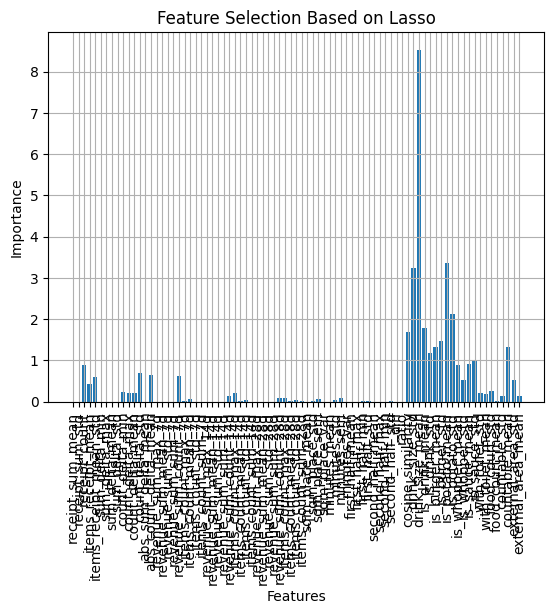

In [441]:
# Using np.abs() to make coefficients positive.
lasso1_coef = np.abs(lasso_cv.best_estimator_.coef_)

# plotting the Column Names and Importance of Columns.
plt.bar(df_train_non_churn_only.columns, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

In [455]:
feature_subset=np.array(df_train_non_churn_only.columns)[lasso1_coef>0.1]
feature_subset

array(['receipt_count', 'items_receipt_mean', 'items_receipt_mean_std',
       'count_delta_min', 'count_delta_max', 'count_delta_mean',
       'count_delta_std', 'abs_count_delta_mean', 'revenue_sum_count_7d',
       'revenue_sum_count_14d', 'items_count_max_14d',
       'cosine_similarity', 'drink_size_std', 'drink_size_mean',
       'is_drink_mean', 'is_drink_std', 'is_burger_mean', 'is_burger_std',
       'is_potato_mean', 'is_potato_std', 'is_whopper_mean',
       'is_whopper_std', 'is_sauce_mean', 'is_sauce_std',
       'with_toilet_std', 'with_toilet_mean', 'food_court_std',
       'countable_std', 'countable_mean', 'external_area_std',
       'external_area_mean'], dtype=object)

In [461]:

X_train, X_val, y_train, y_val = train_test_split(df_train_non_churn_only, df_target_non_churn_only, test_size=0.2, random_state=42)
evaluate_model(lasso_cv.best_estimator_, X_val, y_val)

14.442212956848454

In [30]:
feature_subset = ['receipt_count', 'items_receipt_mean', 'items_receipt_mean_std',
       'count_delta_min', 'count_delta_max', 'count_delta_mean',
       'count_delta_std', 'abs_count_delta_mean', 'revenue_sum_count_7d',
       'revenue_sum_count_14d', 'items_count_max_14d',
       'cosine_similarity', 'drink_size_std', 'drink_size_mean',
       'is_drink_mean', 'is_drink_std', 'is_burger_mean', 'is_burger_std',
       'is_potato_mean', 'is_potato_std', 'is_whopper_mean',
       'is_whopper_std', 'is_sauce_mean', 'is_sauce_std',
       'with_toilet_std', 'with_toilet_mean', 'food_court_std',
       'countable_std', 'countable_mean', 'external_area_std',
       'external_area_mean']

In [31]:
df_train_non_churn_only_selected_features = df_train_non_churn_only[feature_subset]

<Axes: >

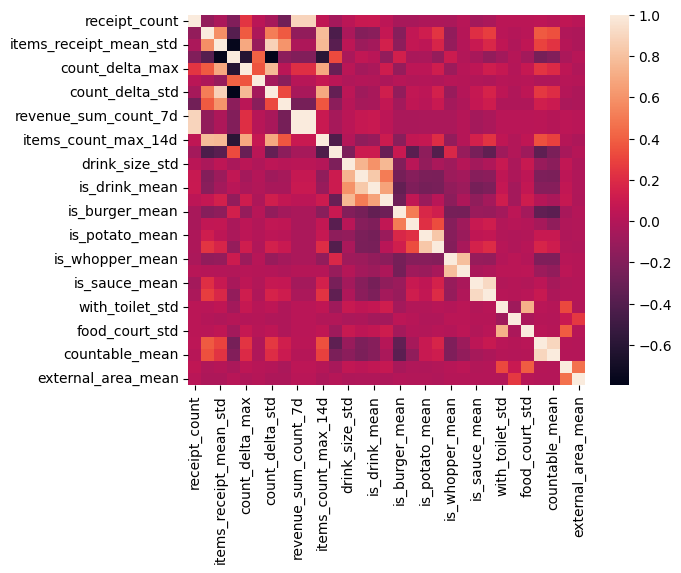

In [458]:
sns.heatmap(df_train_non_churn_only_selected_features.corr())

In [459]:
quick_evaluate_model(Lasso(alpha=1e-5), df_train_non_churn_only_selected_features, df_target_non_churn_only)

14.566393754182654

In [460]:
from sklearn.linear_model import Ridge

quick_evaluate_model(Ridge(), df_train_non_churn_only_selected_features, df_target_non_churn_only)

14.56639171327122

In [462]:
from sklearn.linear_model import ElasticNetCV

quick_evaluate_model(ElasticNetCV(), df_train_non_churn_only_selected_features, df_target_non_churn_only)

14.57457299003521

In [465]:
quick_evaluate_model(ElasticNetCV(l1_ratio=0.7, alphas=[1e-6]), df_train_non_churn_only_selected_features, df_target_non_churn_only)

C:\Users\rakhmerov\.virtualenvs\pythonProject3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.314e+07, tolerance: 7.028e+03
  model = cd_fast.enet_coordinate_descent(


14.566398377756258

14.566399537873147

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [467]:
scoring = make_scorer(r2_score)
g_cv = GridSearchCV(DecisionTreeRegressor(random_state=0),
              param_grid={'min_samples_split': range(2, 10)},
              scoring=scoring, cv=5, refit=True)

g_cv.fit(X_train, y_train)
g_cv.best_params_

result = g_cv.cv_results_
# print(result)
r2_score(y_val, g_cv.best_estimator_.predict(X_val))

-0.5317899267252506

In [470]:
evaluate_model(g_cv.best_estimator_, X_val, y_val)

19.36370867472099

In [471]:
g_cv.best_estimator_.feature_importances_

array([0.01048933, 0.01039218, 0.17505316, 0.00750189, 0.00849253,
       0.01786482, 0.0184287 , 0.01631254, 0.01756927, 0.00675163,
       0.00768486, 0.00971429, 0.01286468, 0.02076093, 0.00712464,
       0.00432984, 0.00325736, 0.00528396, 0.00410352, 0.01355944,
       0.00168105, 0.00270397, 0.00374999, 0.00289073, 0.00444635,
       0.00346581, 0.00528735, 0.00421614, 0.01364637, 0.00152308,
       0.00288449, 0.00372532, 0.0028034 , 0.00452915, 0.00375227,
       0.00519788, 0.00392505, 0.00753203, 0.00196441, 0.00273724,
       0.00357166, 0.00236244, 0.03078123, 0.00693678, 0.00686401,
       0.00684467, 0.03442732, 0.01197384, 0.01335229, 0.01220658,
       0.01180207, 0.01201785, 0.01374117, 0.01242915, 0.01326633,
       0.01112282, 0.02020958, 0.0178829 , 0.01449981, 0.01597845,
       0.02727169, 0.02022966, 0.01626367, 0.01114221, 0.01291278,
       0.01820215, 0.01773129, 0.01313005, 0.01513199, 0.01116465,
       0.01095442, 0.01016775, 0.01085497, 0.0087775 , 0.01005

In [473]:
g_cv.best_params_

{'min_samples_split': 9}

In [475]:
quick_evaluate_model(DecisionTreeRegressor(min_samples_split=9), df_train_non_churn_only_selected_features, df_target_non_churn_only)

19.11404129369491

In [485]:
dtr = DecisionTreeRegressor(min_samples_split=9)
X_train_sf, X_val_sf, y_train_sf, y_val_sf = train_test_split(df_train_non_churn_only_selected_features, df_target_non_churn_only, test_size=0.2, random_state=42)
dtr.fit

<bound method DecisionTreeRegressor.fit of DecisionTreeRegressor(min_samples_split=9)>

In [476]:
df_train_non_churn_only_selected_features

,receipt_count,items_receipt_mean,items_receipt_mean_std,count_delta_min,count_delta_max,count_delta_mean,count_delta_std,abs_count_delta_mean,revenue_sum_count_7d,revenue_sum_count_14d,...,is_whopper_std,is_sauce_mean,is_sauce_std,with_toilet_std,with_toilet_mean,food_court_std,countable_std,countable_mean,external_area_std,external_area_mean
140905,25,1.360000,0.860233,-3.0,2.0,-0.125,1.075922,0.125,7,7,...,0.386953,0.088235,0.287902,0.000000,1.00,0.000000,0.171499,0.029412,0.359491,0.147059
140906,25,2.440000,1.916594,-6.0,6.0,0.000,2.620986,0.000,18,18,...,0.179556,0.180328,0.387651,0.000000,1.00,0.000000,0.300273,0.098361,0.000000,1.000000
140907,24,3.583333,1.909169,-5.0,4.0,0.000,2.467977,0.000,18,18,...,0.348536,0.418605,0.496224,0.000000,0.00,0.000000,0.235380,0.058140,0.000000,0.000000
140908,4,2.500000,0.577350,-1.0,1.0,0.000,1.000000,0.000,4,4,...,0.316228,0.000000,0.000000,0.000000,0.00,0.421637,0.000000,0.000000,0.421637,0.800000
140909,3,8.333333,1.154701,-2.0,0.0,-1.000,1.414214,1.000,3,3,...,0.331662,0.280000,0.458258,0.458258,0.28,0.458258,0.374166,0.160000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,3,5.333333,5.859465,-9.0,-2.0,-5.500,4.949747,5.500,3,3,...,0.000000,0.000000,0.000000,0.000000,1.00,0.000000,0.341565,0.125000,0.000000,1.000000
499996,3,4.333333,0.577350,-1.0,1.0,0.000,1.414214,0.000,3,3,...,0.000000,0.230769,0.438529,0.000000,1.00,0.000000,0.518875,0.461538,0.000000,1.000000
499997,4,3.000000,1.414214,-2.0,0.0,-1.000,1.000000,1.000,4,4,...,0.389249,0.166667,0.389249,0.000000,1.00,0.000000,0.389249,0.166667,0.000000,0.000000
499998,3,3.666667,1.527525,1.0,2.0,1.500,0.707107,1.500,3,3,...,0.301511,0.181818,0.404520,0.000000,0.00,0.000000,0.404520,0.181818,0.000000,0.000000


In [477]:
from sklearn.linear_model import SGDRegressor

quick_evaluate_model(SGDRegressor(), df_train_non_churn_only_selected_features, df_target_non_churn_only)

14.70451244416872

In [2]:
from sklearn.svm import LinearSVR

quick_evaluate_model(LinearSVR(), df_train_non_churn_only_selected_features, df_target_non_churn_only)

NameError: name 'quick_evaluate_model' is not defined

In [483]:
g_cv = GridSearchCV(SGDRegressor(),
              param_grid={'alpha': np.arange(1e-6, 1, 10)},
              scoring=make_scorer(mean_squared_error), cv=5, refit=True)

g_cv.fit(X_train, y_train)
g_cv.best_params_

result = g_cv.cv_results_
# print(result)
mean_squared_error(y_val, g_cv.best_estimator_.predict(X_val))

9.437270023776493e+32

In [492]:
g_cv = GridSearchCV(SGDRegressor(),
              param_grid={'alpha': np.arange(1e-6, 1, 10)},
              scoring=make_scorer(mean_squared_error, greater_is_better=False), cv=5, refit=True)

g_cv.fit(X_train_sf, y_train_sf)
g_cv.best_params_

result = g_cv.cv_results_
# print(result)
mean_squared_error(y_val_sf, g_cv.best_estimator_.predict(X_val_sf))

237.24283902596835

In [491]:
quick_evaluate_model(SGDRegressor(alpha=0.01), df_train_non_churn_only_selected_features, df_target_non_churn_only)

14.610180056026826

ещё почистить сами данные?


In [493]:
df_train_non_churn_only_selected_features

,receipt_count,items_receipt_mean,items_receipt_mean_std,count_delta_min,count_delta_max,count_delta_mean,count_delta_std,abs_count_delta_mean,revenue_sum_count_7d,revenue_sum_count_14d,...,is_whopper_std,is_sauce_mean,is_sauce_std,with_toilet_std,with_toilet_mean,food_court_std,countable_std,countable_mean,external_area_std,external_area_mean
140905,25,1.360000,0.860233,-3.0,2.0,-0.125,1.075922,0.125,7,7,...,0.386953,0.088235,0.287902,0.000000,1.00,0.000000,0.171499,0.029412,0.359491,0.147059
140906,25,2.440000,1.916594,-6.0,6.0,0.000,2.620986,0.000,18,18,...,0.179556,0.180328,0.387651,0.000000,1.00,0.000000,0.300273,0.098361,0.000000,1.000000
140907,24,3.583333,1.909169,-5.0,4.0,0.000,2.467977,0.000,18,18,...,0.348536,0.418605,0.496224,0.000000,0.00,0.000000,0.235380,0.058140,0.000000,0.000000
140908,4,2.500000,0.577350,-1.0,1.0,0.000,1.000000,0.000,4,4,...,0.316228,0.000000,0.000000,0.000000,0.00,0.421637,0.000000,0.000000,0.421637,0.800000
140909,3,8.333333,1.154701,-2.0,0.0,-1.000,1.414214,1.000,3,3,...,0.331662,0.280000,0.458258,0.458258,0.28,0.458258,0.374166,0.160000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,3,5.333333,5.859465,-9.0,-2.0,-5.500,4.949747,5.500,3,3,...,0.000000,0.000000,0.000000,0.000000,1.00,0.000000,0.341565,0.125000,0.000000,1.000000
499996,3,4.333333,0.577350,-1.0,1.0,0.000,1.414214,0.000,3,3,...,0.000000,0.230769,0.438529,0.000000,1.00,0.000000,0.518875,0.461538,0.000000,1.000000
499997,4,3.000000,1.414214,-2.0,0.0,-1.000,1.000000,1.000,4,4,...,0.389249,0.166667,0.389249,0.000000,1.00,0.000000,0.389249,0.166667,0.000000,0.000000
499998,3,3.666667,1.527525,1.0,2.0,1.500,0.707107,1.500,3,3,...,0.301511,0.181818,0.404520,0.000000,0.00,0.000000,0.404520,0.181818,0.000000,0.000000


In [494]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
df_train_non_churn_only_selected_features_scaled = min_max_scaler.fit_transform(df_train_non_churn_only_selected_features, df_target_non_churn_only)


In [495]:
X_train_sf_scaled, X_val_sf_scaled, y_train_sf_scaled, y_val_sf_scaled = train_test_split(df_train_non_churn_only_selected_features_scaled, df_target_non_churn_only, test_size=0.2, random_state=42)

In [496]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
# Polynomial transformation of degree 2
poly_features = PolynomialFeatures(degree = 2)
# Returns a transformed version of X with new features
X_train_scaled_poly = poly_features.fit_transform(X_train_sf_scaled)
X_test_scaled_poly = poly_features.fit_transform(X_val_sf_scaled)
poly_reg = LinearRegression()
poly_reg_score = cross_val_score(poly_reg, X_train_scaled_poly, y_train, verbose = 2)
poly_reg.fit(X_train_scaled_poly, y_train_sf_scaled)
y_pred = poly_reg.predict(X_test_scaled_poly)
poly_reg.score(X_test_scaled_poly, y_val_sf_scaled)

[CV] END .................................................... total time=   7.6s
[CV] END .................................................... total time=  10.3s
[CV] END .................................................... total time=   8.3s
[CV] END .................................................... total time=  10.8s
[CV] END .................................................... total time=   9.5s


0.13132436545868842

In [497]:
quick_evaluate_model(poly_reg, df_train_non_churn_only_selected_features_scaled, df_target_non_churn_only)

14.565912682729788

In [498]:
from sklearn.ensemble import GradientBoostingRegressor

quick_evaluate_model(GradientBoostingRegressor(), df_train_non_churn_only_selected_features_scaled, df_target_non_churn_only)

14.143291852890636

In [499]:
quick_evaluate_model(AdaBoostRegressor(Lasso()), df_train_non_churn_only_selected_features_scaled, df_target_non_churn_only)

15.654533834028282

In [500]:
quick_evaluate_model(AdaBoostRegressor(DecisionTreeRegressor()), df_train_non_churn_only_selected_features_scaled, df_target_non_churn_only)

15.230720391290319

In [501]:
from xgboost import XGBRegressor

quick_evaluate_model(XGBRegressor(), df_train_non_churn_only_selected_features_scaled, df_target_non_churn_only)

14.203574067063132

In [502]:
selected_features_05 = np.array(df_train_non_churn_only.columns)[lasso1_coef > 0.5]
selected_features_05

array(['receipt_count', 'items_receipt_mean_std', 'count_delta_std',
       'abs_count_delta_mean', 'revenue_sum_count_7d',
       'cosine_similarity', 'drink_size_std', 'drink_size_mean',
       'is_drink_mean', 'is_drink_std', 'is_burger_mean', 'is_burger_std',
       'is_potato_mean', 'is_potato_std', 'is_whopper_mean',
       'is_whopper_std', 'is_sauce_mean', 'is_sauce_std',
       'countable_mean', 'external_area_std'], dtype=object)

In [504]:
from sklearn.ensemble import GradientBoostingRegressor

quick_evaluate_model(GradientBoostingRegressor(), df_train_non_churn_only_selected_features, df_target_non_churn_only)

14.143339205882565

In [505]:
quick_evaluate_model(GradientBoostingRegressor(), df_train_non_churn_only_selected_features[selected_features_05], df_target_non_churn_only)

14.153860264437766

In [506]:
quick_evaluate_model(LinearRegression(), df_train_non_churn_only_selected_features[selected_features_05], df_target_non_churn_only)

14.61682093411727

In [ ]:
X_train_sf, X__sfval, y_train_sf, y_val_sf = train_test_split(df_train_non_churn_only_selected_features, df_target_non_churn_only, test_size=0.2,
                                                  random_state=42)

In [34]:
scoring = make_scorer(mean_squared_error, greater_is_better=False)
g_cv = GridSearchCV(DecisionTreeRegressor(random_state=0),
              param_grid={'min_samples_split': range(2, 10)},
              scoring=scoring, cv=5, refit=True, n_jobs=-1)

g_cv.fit(X_train, y_train)
g_cv.best_params_

result = g_cv.cv_results_
# print(result)
mean_squared_error(y_val, g_cv.best_estimator_.predict(X_val))

1104.7449358451956

In [35]:
dtr = DecisionTreeRegressor()
dtr.fit(df_train_non_churn_only_selected_features, df_target_non_churn_only)
dtr.feature_importances_

array([0.15389989, 0.02990626, 0.03332831, 0.01752322, 0.01837502,
       0.02442033, 0.03529478, 0.01790142, 0.02246064, 0.01260585,
       0.01951162, 0.06593993, 0.05182279, 0.04644597, 0.02551222,
       0.02897303, 0.0381837 , 0.03706559, 0.02975889, 0.03215126,
       0.02559307, 0.02685264, 0.02387726, 0.02556754, 0.0215712 ,
       0.02602166, 0.02468304, 0.02663294, 0.02441318, 0.01575473,
       0.017952  ])

In [36]:
quick_evaluate_model(DecisionTreeRegressor(), df_train_non_churn_only_selected_features, df_target_non_churn_only)

20.36784534856643

In [37]:
quick_evaluate_model(GradientBoostingRegressor(), df_train_non_churn_only_selected_features, df_target_non_churn_only)

14.143282371094662

In [38]:
quick_evaluate_model(GradientBoostingRegressor(n_estimators=500), df_train_non_churn_only_selected_features, df_target_non_churn_only)

14.138175688912526

In [39]:
df_train_v4 = pd.read_parquet('train_with_feats_v4.parquet')

In [40]:
df_train_v4

,buy_post,customer_id,receipt_sum_mean,receipt_sum_std,receipt_count,items_receipt_mean,items_receipt_mean_std,sum_delta_min,sum_delta_max,sum_delta_mean,...,is_sauce_mean,is_sauce_std,with_toilet_std,with_toilet_mean,food_court_std,food_court_mean,countable_std,countable_mean,external_area_std,external_area_mean
0,0,45006,522.613333,395.184669,3,6.333333,5.773503,-765.91,213.99,-275.960000,...,0.052632,0.229416,0.374634,0.157895,0.374634,0.842105,0.418854,0.210526,0.000000,0.000000
1,0,45303,148.943478,88.418075,23,1.260870,0.751809,-250.00,288.99,-0.908182,...,0.241379,0.435494,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0,102488,186.978333,331.158229,6,3.000000,4.427189,-830.94,830.94,0.200000,...,0.166667,0.383482,0.383482,0.833333,0.383482,0.166667,0.323381,0.111111,0.427793,0.777778
3,0,119045,396.970000,191.625756,3,2.000000,1.000000,-300.97,-55.00,-177.985000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.516398,0.333333,0.000000,0.000000
4,0,157470,679.296667,621.355704,3,5.000000,3.605551,-806.96,-414.97,-610.965000,...,0.333333,0.487950,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1,46598535,353.000000,129.722781,3,5.333333,5.859465,-242.00,40.00,-101.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.341565,0.125000,0.000000,1.000000
499996,1,46609455,528.290000,125.825938,3,4.333333,0.577350,-249.99,99.99,-75.000000,...,0.230769,0.438529,0.000000,1.000000,0.000000,0.000000,0.518875,0.461538,0.000000,1.000000
499997,1,46617009,562.470000,321.818220,4,3.000000,1.414214,-584.98,130.01,-249.990000,...,0.166667,0.389249,0.000000,1.000000,0.000000,0.000000,0.389249,0.166667,0.000000,0.000000
499998,1,46639170,363.306667,177.842347,3,3.666667,1.527525,119.99,229.98,174.985000,...,0.181818,0.404520,0.000000,0.000000,0.000000,1.000000,0.404520,0.181818,0.000000,0.000000


In [41]:
df_all = pd.merge(df_train_v4, df_targets_raw, on=['customer_id'])
df_all_dropna = df_all.dropna()
df_train_feats_non_churn_v4 = df_all_dropna.drop(columns=['buy_post', 'customer_id', 'date_diff_post'])
df_targets_non_churn_v4 = df_all_dropna.date_diff_post

In [47]:
X_train_v4, X_val_v4, y_train_v4, y_val_v4 = train_test_split(df_train_feats_non_churn_v4, df_targets_non_churn_v4, test_size=0.2,
                                                  random_state=42)

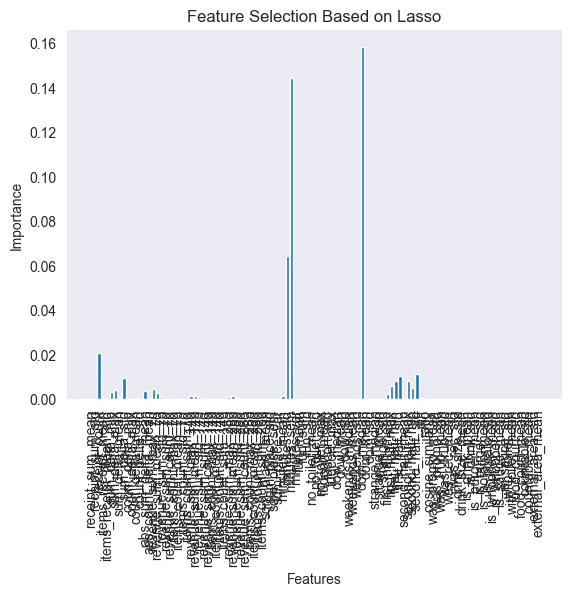

In [48]:
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV()
lasso_cv.fit(X_train_v4, y_train_v4)

# Using np.abs() to make coefficients positive.
lasso1_coef = np.abs(lasso_cv.coef_)

# plotting the Column Names and Importance of Columns.
plt.bar(df_train_feats_non_churn_v4.columns, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

In [57]:
feature_subset=np.array(df_train_feats_non_churn_v4.columns)[lasso1_coef>0.001]
print("Selected Feature Columns: {}".format(feature_subset))

Selected Feature Columns: ['receipt_count' 'sum_delta_min' 'sum_delta_max' 'sum_delta_std'
 'abs_sum_delta_mean' 'revenue_sum_max_7d' 'revenue_sum_mean_7d'
 'revenue_sum_max_14d' 'revenue_sum_mean_14d' 'revenue_sum_max_28d'
 'revenue_sum_mean_28d' 'minutes_mean' 'minutes_std' 'minutes_sem'
 'dom_median' 'first_half_mean' 'first_half_max' 'first_half_min'
 'first_half_std' 'second_half_max' 'second_half_min' 'second_half_std']


In [58]:
quick_evaluate_model(GradientBoostingRegressor(n_estimators=500), df_train_feats_non_churn_v4[feature_subset], df_targets_non_churn_v4)

13.631397061223234

In [61]:
quick_evaluate_model(GradientBoostingRegressor(n_estimators=1000), df_train_feats_non_churn_v4[feature_subset], df_targets_non_churn_v4)

13.636717544871761

In [ ]:
GradientBoostingRegressor(n_estimators=500)

In [54]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lm, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
scores

In [60]:
import lightautoml

TypeError: cannot set 'get_record_history_wrapper' attribute of immutable type 'object'

In [ ]:
from lightautoml.automl.base import AutoML
from lightautoml.ml_algo.boost_lgbm import BoostLGBM
from lightautoml.ml_algo.tuning.optuna import OptunaTuner
from lightautoml.pipelines.features.lgb_pipeline import LGBSimpleFeatures
from lightautoml.pipelines.ml.base import MLPipeline
from lightautoml.reader.base import PandasToPandasReader
from lightautoml.tasks import Task

In [ ]:
# Standard python libraries
import os
import requests

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

In [ ]:
N_THREADS = 8
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 300
TARGET_NAME = 'date_diff_post'

In [ ]:
task = Task('reg')
df_automl = df_all.dropna()
roles = {
    'target': TARGET_NAME,
    'drop': ['customer_id', 'buy_post']
}

train_data, test_data = train_test_split(
    df_automl,
    test_size=TEST_SIZE,
    stratify=df_automl[TARGET_NAME],
    random_state=RANDOM_STATE
)

automl = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

out_of_fold_predictions = automl.fit_predict(df_automl, roles = roles, verbose = 1)
test_predictions = automl.predict(test_data)

In [ ]:
print(f'OOF score: {np.sqrt(mean_squared_error(df_automl[TARGET_NAME].values, out_of_fold_predictions.data[:, 0]))}')
print(f'HOLDOUT score: {np.sqrt(mean_squared_error(df_automl[TARGET_NAME].values, test_predictions.data[:, 0]))}')

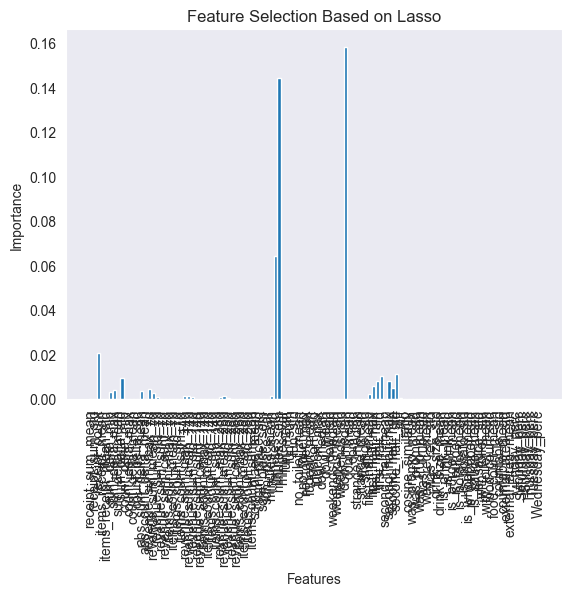

In [62]:
df_train_v5 = pd.read_parquet('train_with_feats_v5.parquet')
df_all_5 = pd.merge(df_train_v5, df_targets_raw, on=['customer_id'])
df_all_dropna_5 = df_all_5.dropna()
df_train_feats_non_churn_v5 = df_all_dropna_5.drop(columns=['buy_post', 'customer_id', 'date_diff_post'])
df_targets_non_churn_v5 = df_all_dropna_5.date_diff_post

X_train_v5, X_val_v5, y_train_v5, y_val_v5 = train_test_split(df_train_feats_non_churn_v5, df_targets_non_churn_v5, test_size=0.2,
                                                  random_state=42)

lasso_cv = LassoCV()
lasso_cv.fit(X_train_v5, y_train_v5)

# Using np.abs() to make coefficients positive.
lasso1_coef = np.abs(lasso_cv.coef_)

# plotting the Column Names and Importance of Columns.
plt.bar(df_train_feats_non_churn_v5.columns, lasso1_coef)
plt.xticks(rotation=90)
plt.grid()
plt.title("Feature Selection Based on Lasso")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

In [69]:
feature_subset = np.array(df_train_feats_non_churn_v5.columns)[lasso1_coef > 0.001]
print("Selected Feature Columns: {}".format(feature_subset))
quick_evaluate_model(GradientBoostingRegressor(n_estimators=500), df_train_feats_non_churn_v5[feature_subset], df_targets_non_churn_v5)

Selected Feature Columns: ['receipt_count' 'sum_delta_min' 'sum_delta_max' 'sum_delta_std'
 'abs_sum_delta_mean' 'revenue_sum_max_7d' 'revenue_sum_mean_7d'
 'revenue_sum_max_14d' 'revenue_sum_mean_14d' 'revenue_sum_max_28d'
 'revenue_sum_mean_28d' 'minutes_mean' 'minutes_std' 'minutes_sem'
 'dom_median' 'first_half_mean' 'first_half_max' 'first_half_min'
 'first_half_std' 'second_half_max' 'second_half_min' 'second_half_std']


13.631256442104528

In [70]:
len(feature_subset)

22

In [66]:
np.array(df_train_feats_non_churn_v5.columns)[lasso1_coef > 0.15]

array(['dom_median'], dtype=object)

In [68]:
lasso_cv.coef_

array([-0.00000000e+00,  0.00000000e+00, -2.06101027e-02, -0.00000000e+00,
        0.00000000e+00,  3.00524239e-03, -3.89647905e-03, -0.00000000e+00,
        9.26753813e-03,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  3.43204022e-03,  0.00000000e+00,  4.34885811e-03,
       -2.85485184e-03, -9.95640545e-04,  8.10527786e-05, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        1.19474913e-03, -1.56742910e-03, -7.38414473e-04,  6.07369448e-06,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  1.03336550e-03, -1.19010473e-03, -4.98684215e-04,
        3.22397857e-06, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.44829077e-05,  1.42528942e-03, -6.40421271e-02,
        1.44323533e-01,  9.13148706e-06, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  